# Tutorial: Spatial transcriptome data

We demonstrate a noise reduction with RECODE for spatial transcriptome data. We use spatial transcriptome data of mouse embryos at E16.5, which is generated by Stereo-seq. The dataset is available from [MOSTA](https://db.cngb.org/stomics/mosta/download/). 

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import scanpy as sc
import numpy as np
import screcode
import warnings
warnings.simplefilter('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/E16.5_E1S1.MOSTA.h5ad'
Raw_key = "count"
adata = sc.read_h5ad("%s" % (input_filename))
adata.var_names_make_unique()
adata = adata[:,np.sum(adata.X,axis=0)>0]
adata.layers["Raw"] = adata.layers[Raw_key].toarray()
adata.layers["Proceed"] = adata.X
adata.X = adata.layers["Raw"]
adata

AnnData object with n_obs × n_vars = 121767 × 28204
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - AI987944', 'Regulon - Alx1', 'Regulon - Alx4', 'Regulon - Arid3a', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Atf1', 'Regulon - Atf2', 'Regulon - Atf3', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Atoh1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barhl2', 'Regulon - Barx1', 'Regulon - Bcl6', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlhe40', 'Regulon - Bmyc', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpb', 'Regulon - Cebpe', 'Regulon - Cic', 'Regulon - Clock', 'Regulon - Creb1', 'Regulon - Creb3l1', 'Regulon - Creb3l2', 'Regulon - Creb5', 'Regulon - Crebl2', 'Regulon - Ctcf', 'Regulon - Ctcfl', 'Regulon - Cux1', 'Regulon - Dbp', 'Regulon - Dbx1', 'Regulon - Ddit3', 'Regulon - Dlx1', 'Regulon - Dlx2', 'Regulon - Dlx

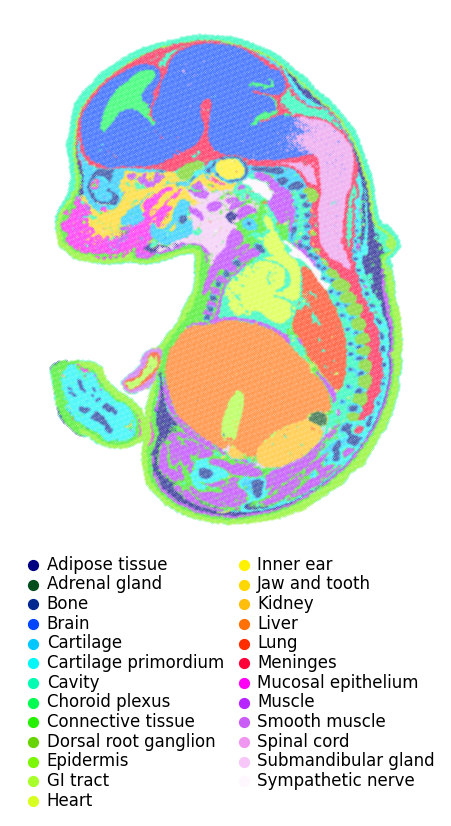

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

clusters = adata.obs["annotation"]
cluster_set = np.unique(clusters)
sp_x, sp_y = adata.obsm["spatial"][:,0], -adata.obsm["spatial"][:,1]
psize = 0.02
figsize=(5,7)
colors = cm.get_cmap('gist_ncar', 25)

fig,ax = plt.subplots(figsize=figsize)
for i  in range(len(cluster_set)):
    idx_ = clusters == cluster_set[i]
    ax.scatter(sp_x[idx_], sp_y[idx_],s=psize,label=cluster_set[i], color=colors(i))
ax.axis('off')
ax.legend(markerscale=50,bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0, fontsize=12,ncol=2,columnspacing=0.2,labelspacing=0.1,handletextpad=-0.2,frameon=False)

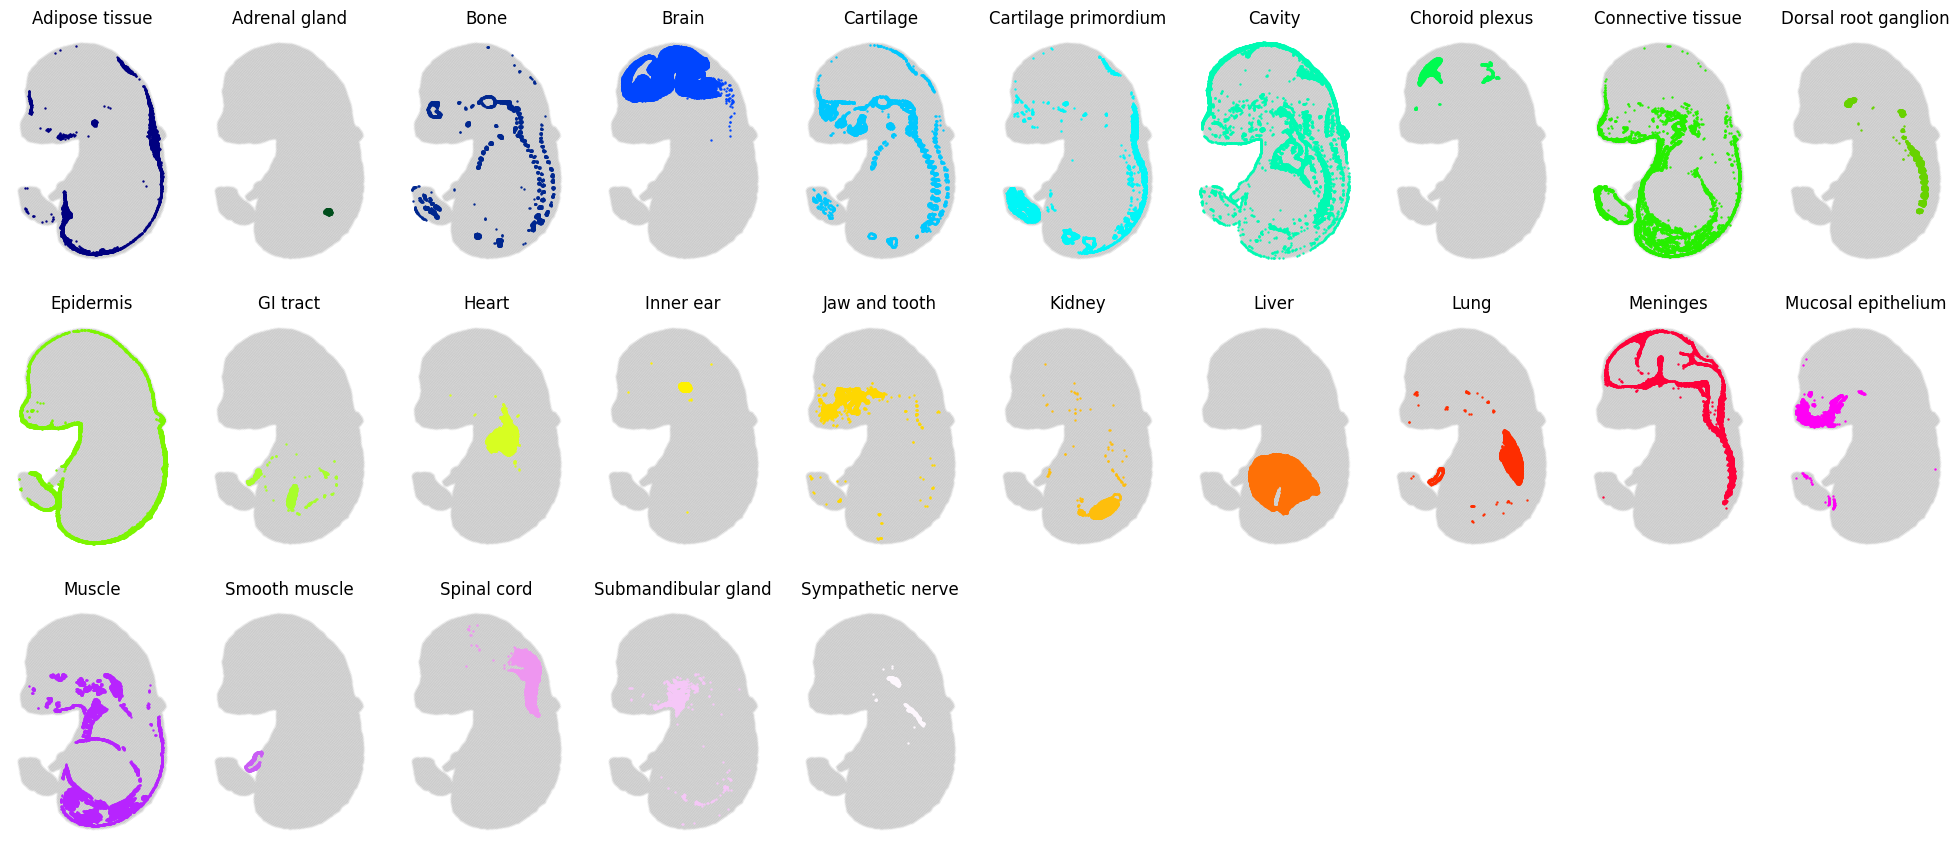

In [4]:
import matplotlib.cm as cm
import math

clusters = adata.obs["annotation"]
cluster_set = np.unique(clusters)
sp_x, sp_y = adata.obsm["spatial"][:,0], -adata.obsm["spatial"][:,1]
psize = 0.5
figsize=(2.5,3.5)
n_cols = 10
n_rows = math.ceil(len(cluster_set)/n_cols)
colors = cm.get_cmap('gist_ncar', 25)

fig,ax = plt.subplots(n_rows,n_cols,figsize=(figsize[0]*n_cols,figsize[1]*n_rows))
[[ax[i,j].axis('off') for i in range(n_rows)] for j in range(n_cols)]
for i  in range(len(cluster_set)):
    idx_ = clusters == cluster_set[i]
    row_ = int(i / n_cols)
    col_ = i % n_cols
    ax_ = ax[row_,col_]
    ax_.scatter(sp_x, sp_y,s=0.01,color="gray",alpha=0.1)
    ax_.scatter(sp_x[idx_], sp_y[idx_],s=psize,color=colors(i))
    ax_.axis('off')
    ax_.set_title(cluster_set[i])

## Apply RECODE
Apply RECODE to the count matrix (without using spatial coordinates).

In [5]:
import importlib
importlib.reload(screcode)

recode = screcode.RECODE(seq_target='RNA',version=2,fast_algorithm_ell_ub=3500)
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 23362, '#non-significant genes': 3062, '#silent genes': 0, 'ell': 3049, 'Elapsed time': '0h 17m 48s 400ms', 'solver': 'randomized', '#test_data': 24353}


### Performance check

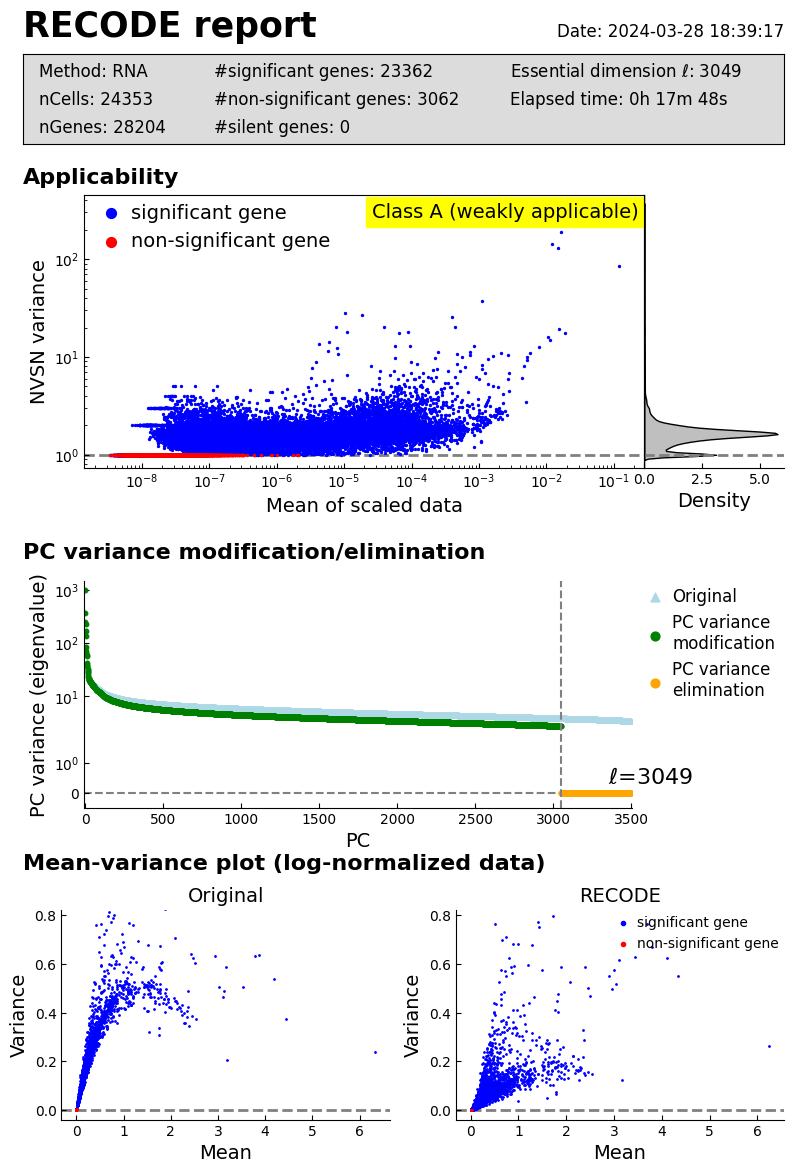

In [6]:
recode.report()

Log normalizaation

In [7]:
target_sum = 1e+4
adata = recode.lognormalize(adata,target_sum=target_sum)

Normalized data are stored in "RECODE_norm" and "RECODE_log"


In [8]:
adata.layers["Raw_norm"] = target_sum*adata.layers[Raw_key].toarray()/np.sum(adata.layers[Raw_key].toarray(),axis=1)[:,np.newaxis]
adata.layers["Raw_log"] = np.log(adata.layers["Raw_norm"]+1)

Plot spatial gene expression

In [9]:
def spatial_gex(
        genes,
        sp_x = adata.obsm["spatial"][:,0], 
        sp_y = -adata.obsm["spatial"][:,1],
        psize = 1,
        figsize=(2.5,3.5),
        dpi=100,
        percentiles = [0,99],
        fs_title = 20,
        fs_label = 20,
    ):
    fig,ax = plt.subplots(2,len(genes),figsize=(figsize[0]*len(genes),figsize[1]*2),tight_layout=True)
    for i in range(len(genes)):
        idx_gene = adata.var.index == genes[i]
        exp = adata.layers["RECODE_log"][:,idx_gene]
        vmin,vmax = np.percentile(exp,percentiles[0]),np.percentile(exp,percentiles[1])
        ax_ = ax[1,i]
        ax_.scatter(sp_x, sp_y,c=exp,s=psize,marker="H",vmin=vmin,vmax=vmax)
        if i== 0:
            ax_.set_ylabel("RECODE",fontsize=fs_label)
            ax_.tick_params(bottom=False, left=False, right=False, top=False,
                            labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            [ax_.spines[c_].set_visible(False) for c_ in ['right','top','bottom','left']]
        else:
            ax_.axis('off')

        
        exp = adata.layers["Raw_log"][:,idx_gene]
        ax_ = ax[0,i]
        ax_.scatter(sp_x, sp_y,c=exp,s=psize,marker="H",vmin=vmin,vmax=vmax)
        ax_.set_title("$\it{%s}$" % genes[i],fontsize=fs_title)
        if i== 0:
            ax_.set_ylabel("Raw",fontsize=fs_label)
            ax_.tick_params(bottom=False, left=False, right=False, top=False,
                            labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            [ax_.spines[c_].set_visible(False) for c_ in ['right','top','bottom','left']]
        else:
            ax_.axis('off')

spatial_gex(genes = ["Arnt2", "Foxc2", "Gata4", "Sox9", "Mef2c", "Grhl2", "Adh1"])
spatial_gex(genes = ["Tbx20","Myl7","Ibsp", "Myh11", "Ahsg", "Akr1b7"])

SyntaxError: invalid syntax (503754885.py, line 15)